# Natural Language Processing with TensorFlow: is a tweet referring to disaster or not?

This notebook covers:

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
Modelling a text dataset
    * Starting with a baseline (TF-IDF)
    * Building several deep learning text models
        * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Saving and loading a trained model
* Find the most wrong predictions




In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py # Download helper functions script

--2024-01-02 12:18:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-02 12:18:17 (67.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import * # Import series of helper functions for the notebook

# download a text dataset. We'll be using the Real or Not? dataset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about disasters, for example:

Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano

The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip # Download data (same as from Kaggle https://www.kaggle.com/c/nlp-getting-started/data)

--2024-01-02 12:18:19--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 142.251.172.207, 108.177.112.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2024-01-02 12:18:19 (53.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
unzip_data("/content/nlp_getting_started.zip") # Unzip data

## Visualize text dataset

In [ ]:
# Turn .csv files into pandas DataFrame's
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
# Shuffle training dataframe
train_df_shuffled=train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts() # How many examples of each class?

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
import random
# visualize some random training examples
random_index=random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target=row
  print(f"Text: {text} \nTarget: {target}", "(real disaster)" if target>0 else "(not a real disaster)")

Text: BLOG: Rain much needed as drought conditions worsen: Right now Charlotte and much of the surrounding area haveÛ_ http://t.co/OLzaVTJFKH 
Target: 1 (real disaster)
Text: @Rebelmage2 I'm glad you got away XD But My 'be safe' was in reference to a tornado near calgary and drum heller at around 4 :O 
Target: 1 (real disaster)
Text: Sitting still in the #CityofMemphis traffic is like sitting in a war zone! They don't move for the Police.. They don't care 
Target: 0 (not a real disaster)
Text: Seriously do we have to do a tactical riot against the headquarters of Disney and Marvel... 
Target: 0 (not a real disaster)
Text: Lmao that light skin guy blew up on Twitter by talking about how ugly he was as a kid.. 
Target: 0 (not a real disaster)


In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sen, val_sen, train_labels, val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                              train_df_shuffled["target"].to_numpy(),
                                                              test_size=0.1,
                                                              random_state=42)

In [ ]:
len(train_sen), len(val_sen), len(train_labels), len(val_labels) # Check the lengths

(6851, 762, 6851, 762)

## Tokenization and Embedding (converting text into numbers)

In [ ]:
train_sen[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
from tensorflow.keras.layers import  TextVectorization

In [ ]:
# Use the default TextVectorization variables to setup an instance of a TextVectorization object
text_vectorizer=TextVectorization(max_tokens=10000,
                                  standardize="lower_and_strip_punctuation",
                                  split="whitespace",
                                  ngrams=None,
                                  output_mode="int",
                                  output_sequence_length=None,
                                  pad_to_max_tokens=True)

In [ ]:
round(sum([len(i.split()) for i in train_sen])/len(train_sen)) # Find average number of tokens (words) in training Tweets

15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length =10000 # max number of words to have in our vocabulary
max_length=15

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode="int",
                                  output_sequence_length=max_length)


In [ ]:
text_vectorizer.adapt(train_sen) # Fit the text vectorizer to the training text

In [ ]:
# Create sample sentence and tokenize it
sample_sentence="There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence=random.choice(train_sen)
print(random_sentence)
text_vectorizer([random_sentence])

Posted a new song: 'Earthquake' http://t.co/RfTyyZ4GwJ http://t.co/lau0Ay7ahV


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2794,    3,   50,  528,  290,    1,    1,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab=text_vectorizer.get_vocabulary()

# most common token
top_5_words=words_in_vocab[:5]

# least common tokens
bottom_5_words=words_in_vocab[-5:]

print(top_5_words)
print(bottom_5_words)

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an embedding using an Embedding Layer

In [ ]:

embedding= tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                     output_dim=128, # set size of embedding vector
                                     input_length=max_length # how long is each input
                                     )

In [ ]:
embedding

In [ ]:
# Get a random sentence from training set
random_sentence=random.choice(train_sen)
print(random_sentence)

# Embed the random sentence (turn it into numerical representation)
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

@Hendy_21 sure the purdies will be alive with the blight ??


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0301935 , -0.01334282, -0.03986963, ..., -0.03588449,
         -0.00734472, -0.01728147],
        [ 0.00222247,  0.04736983,  0.00033421, ...,  0.0154483 ,
          0.00565826,  0.02234804],
        [-0.00526403, -0.00384519,  0.02247885, ...,  0.0062413 ,
          0.04176443,  0.01280266],
        ...,
        [-0.00393809, -0.01999164,  0.00820333, ...,  0.04546101,
         -0.02851527, -0.02193093],
        [-0.00393809, -0.01999164,  0.00820333, ...,  0.04546101,
         -0.02851527, -0.02193093],
        [-0.00393809, -0.01999164,  0.00820333, ...,  0.04546101,
         -0.02851527, -0.02193093]]], dtype=float32)>

## Modelling a text dataset

we'll be building the following:
 * Model 0: Naive Bayes (baseline)
 * Model 1: Feed-forward neural network (dense model)
 * Model 2: LSTM model
 * Model 3: GRU model
 * Model 4: Bidirectional-LSTM model
 * Model 5: 1D Convolutional Neural Network
 * Model 6: TensorFlow Hub Pretrained Feature Extractor
 * Model 7: Same as model 6 with 10% of training data


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
# Create tokenization and modelling pipeline
model0=Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])



In [ ]:
# Fit the pipeline to the training data
model0.fit(train_sen, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model0.score(val_sen, val_labels) #evaluate the model

In [ ]:
baseline_score

0.7926509186351706

In [ ]:
# Make predictions
baseline_preds=model0.predict(val_sen)
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

### Creating an evaluation function

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true, y_pred):

    # Calculate model accuracy
  model_accuracy= accuracy_score(y_true, y_pred)*100

    # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _=precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results={"accuracy": model_accuracy,
                 "precision": model_precision,
                 "recall": model_recall,
                 "f1_score": model_f1}
  return model_results



In [ ]:
# Get baseline results
baseline_results=calculate_results(val_labels, baseline_preds)

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Model 1: a simple dense model

In [ ]:
Save_Dir="model_logs" # Create directory to save TensorBoard logs

In [ ]:
# Build model with the Functional API
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings

x=text_vectorizer(inputs) # turn the input text into numbers
x=embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model1=tf.keras.Model(inputs, outputs) # construct the model

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [ ]:
# Compile model
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
# Fit the model
model1_hist=model1.fit(x=train_sen, y=train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model1")])

Saving TensorBoard log files to: model_logs/Model1/20240102-121831
Epoch 1/5
215/215 [==============================] - 15s 53ms/step - loss: 0.6143 - accuracy: 0.6894 - val_loss: 0.5385 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4435 - accuracy: 0.8193 - val_loss: 0.4697 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3487 - accuracy: 0.8625 - val_loss: 0.4604 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2861 - accuracy: 0.8901 - val_loss: 0.4635 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2388 - accuracy: 0.9126 - val_loss: 0.4789 - val_accuracy: 0.7782


In [ ]:
model1.evaluate(val_sen, val_labels) # Check the results

24/24 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.7782


[0.47888660430908203, 0.778215229511261]

In [ ]:
model1_pred_probs=model1.predict(val_sen) # Make predictions (these come back in the form of probabilities)

24/24 [==============================] - 0s 2ms/step


In [ ]:
model1_pred_probs[:10]

array([[0.39630663],
       [0.79140425],
       [0.99806446],
       [0.12376892],
       [0.08813255],
       [0.93094504],
       [0.91242605],
       [0.9933563 ],
       [0.9631457 ],
       [0.2731819 ]], dtype=float32)

In [ ]:
model_1_preds=tf.squeeze(tf.round(model1_pred_probs)) # Turn prediction probabilities into single-dimension tensor of floats

In [ ]:
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
model_1_res=calculate_results(val_labels, model_1_preds) # Calculate model_1 metrics

## Visualize learned embedding

In [ ]:
embed_weights=model1.get_layer("embedding").get_weights()[0] # Get the weight matrix of embedding layer

In [ ]:
print(embed_weights.shape)

(10000, 128)


## Model 2: LSTM

In [ ]:
# Create LSTM model
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x=text_vectorizer(inputs)
x=embedding(x)
#x=tf.keras.layers.LSTM(64, return_sequences=True)(x)
x=tf.keras.layers.LSTM(64)(x)
#x=tf.keras.layers.Dense(64, activation="relu")(x)
#x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model2=tf.keras.Model(inputs, outputs)

# Compile model
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")



In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# Fit model
History_2=model2.fit(train_sen, train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model2_LSTM")])

Saving TensorBoard log files to: model_logs/Model2_LSTM/20240102-121857
Epoch 1/5
215/215 [==============================] - 18s 67ms/step - loss: 0.2214 - accuracy: 0.9162 - val_loss: 0.5379 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1590 - accuracy: 0.9404 - val_loss: 0.6213 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1324 - accuracy: 0.9489 - val_loss: 0.6395 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1114 - accuracy: 0.9578 - val_loss: 0.8135 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0876 - accuracy: 0.9669 - val_loss: 0.8532 - val_accuracy: 0.7717


In [ ]:
model2.evaluate(val_sen, val_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.8532 - accuracy: 0.7717


[0.8532106280326843, 0.7716535329818726]

In [ ]:
model2_pred_probs=model2.predict(val_sen) # Round out predictions and reduce to 1-dimensional array

24/24 [==============================] - 1s 5ms/step


In [ ]:
model2_preds=tf.squeeze(tf.round(model2_pred_probs))

In [ ]:
model_2_res=calculate_results(val_labels, model2_preds) # Calculate LSTM model results

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

##Model 3: GRU

In [ ]:
# Build an RNN using the GRU cell
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x=text_vectorizer(inputs)
x=embedding(x)
#x=tf.keras.layers.LSTM(64, return_sequences=True)(x) # stacking recurrent cells requires return_sequences=True
x=tf.keras.layers.GRU(64)(x)
#x=tf.keras.layers.Dense(64, activation="relu")(x)
#x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model3=tf.keras.Model(inputs, outputs)

# Compile GRU model
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")


In [ ]:
model3.summary() # Get a summary of the GRU model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# Fit model
History_3=model3.fit(train_sen, train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model_3_GRU")])

Saving TensorBoard log files to: model_logs/Model_3_GRU/20240102-121934
Epoch 1/5
215/215 [==============================] - 13s 48ms/step - loss: 0.1556 - accuracy: 0.9387 - val_loss: 0.8621 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0859 - accuracy: 0.9666 - val_loss: 0.8958 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0733 - accuracy: 0.9712 - val_loss: 0.8979 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0656 - accuracy: 0.9749 - val_loss: 1.0550 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0577 - accuracy: 0.9768 - val_loss: 1.1172 - val_accuracy: 0.7717


In [ ]:
# Make predictions on the validation data
model3_pred_probs=model3.predict(val_sen)
model3_preds=tf.squeeze(tf.round(model3_pred_probs))

# Calcuate model_3 results
model_3_res=calculate_results(val_labels, model3_preds)

24/24 [==============================] - 0s 5ms/step


## Model 4: Bidirectional LSTM

In [ ]:
# Build a Bidirectional RNN in TensorFlow
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x=text_vectorizer(inputs)
x=embedding(x)
#x=tf.keras.layers.LSTM(64, return_sequences=True)(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM
#x=tf.keras.layers.Dense(64, activation="relu")(x)
#x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model4=tf.keras.Model(inputs, outputs)

# Compile
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
model4.summary() # Get a summary of our bidirectional model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
History_4=model4.fit(train_sen, train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/Model_4_Bidirectional/20240102-122006
Epoch 1/5
215/215 [==============================] - 14s 49ms/step - loss: 0.1072 - accuracy: 0.9670 - val_loss: 0.8685 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0565 - accuracy: 0.9780 - val_loss: 1.1814 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0476 - accuracy: 0.9777 - val_loss: 1.2376 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0468 - accuracy: 0.9793 - val_loss: 1.4229 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0394 - accuracy: 0.9812 - val_loss: 1.3666 - val_accuracy: 0.7638


In [ ]:
# Make predictions with bidirectional RNN on the validation data
model4_pred_probs=model4.predict(val_sen)
model4_preds=tf.squeeze(tf.round(model4_pred_probs))

# Calculate bidirectional RNN model results
model_4_res=calculate_results(val_labels, model4_preds)

24/24 [==============================] - 0s 5ms/step


## Model 5: Conv1D Model

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
inputs=tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x=text_vectorizer(inputs)
x=embedding(x)
x=tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model5=tf.keras.Model(inputs, outputs)

# Compile Conv1D model
model5.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
model5.summary() # Get a summary of the 1D convolution model

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
# Fit the model
History_5=model5.fit(train_sen, train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model_5_conv1D")])

Saving TensorBoard log files to: model_logs/Model_5_conv1D/20240102-122052
Epoch 1/5
215/215 [==============================] - 11s 40ms/step - loss: 0.1193 - accuracy: 0.9623 - val_loss: 0.9510 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0722 - accuracy: 0.9730 - val_loss: 1.0558 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0626 - accuracy: 0.9731 - val_loss: 1.1754 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0552 - accuracy: 0.9791 - val_loss: 1.2133 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0514 - accuracy: 0.9781 - val_loss: 1.2394 - val_accuracy: 0.7612


In [ ]:
# Make predictions with model_5
model5_pred_probs=model5.predict(val_sen)
model5_preds=tf.squeeze(tf.round(model5_pred_probs))

# Calculate model_5 evaluation metrics
model_5_res=calculate_results(val_labels, model5_preds)

24/24 [==============================] - 0s 7ms/step


## Using Pretrained Embeddings (transfer learning for NLP)

In [ ]:
import tensorflow_hub as hub
#pretrained embedding with universal sentence encoder

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

In [ ]:
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133019 -0.06338634 -0.01607501 ... -0.03242779 -0.0457574
   0.05370456]
 [ 0.05080859 -0.01652432  0.01573776 ...  0.00976659  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


## Model 6: TF Hub embedding

In [ ]:
# use this encoding layer in place of the text_vectorizer and embedding layer
sentence_encoder=hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                input_shape=[],
                                dtype=tf.string,
                                trainable=False,
                                name="USE")

In [ ]:
# Create model using the Sequential API
model6=tf.keras.Sequential()
model6.add(sentence_encoder)
model6.add(tf.keras.layers.Dense(64, activation="relu"))
model6.add(tf.keras.layers.Dense(1, activation="sigmoid"))


model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Compile model
model6.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
# Fit model
History_6=model6.fit(train_sen, train_labels, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model_6_USE")])

Saving TensorBoard log files to: model_logs/Model_6_USE/20240102-122202
Epoch 1/5
215/215 [==============================] - 7s 15ms/step - loss: 0.5047 - accuracy: 0.7881 - val_loss: 0.4514 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4166 - accuracy: 0.8161 - val_loss: 0.4412 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4017 - accuracy: 0.8229 - val_loss: 0.4363 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3937 - accuracy: 0.8238 - val_loss: 0.4287 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3874 - accuracy: 0.8295 - val_loss: 0.4290 - val_accuracy: 0.8150


In [ ]:
# Make predictions with USE TF Hub model
model6_pred_probs=model6.predict(val_sen)
model6_preds=tf.squeeze(tf.round(model6_pred_probs))
# Calculate model 6 performance metrics
model_6_res=calculate_results(val_labels, model6_preds)

24/24 [==============================] - 1s 21ms/step


In [ ]:
baseline_results # Compare TF Hub model to baseline

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

## Model 7: USE with 10% of data

In [ ]:
'''train_10_percent=train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sen_10=train_10_percent["text"].to_list()
train_labels_10=train_10_percent["target"].to_list()'''

'train_10_percent=train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)\ntrain_sen_10=train_10_percent["text"].to_list()\ntrain_labels_10=train_10_percent["target"].to_list()'

In [ ]:
#train_labels_10

In [ ]:
#Split training set to only 10 of full data
train_10_percent_split=int(0.1*len(train_sen))
train_sen_10_percent=train_sen[:train_10_percent_split]
train_labels_10_percent=train_labels[:train_10_percent_split]
len(train_labels_10_percent) # Check length of 10 percent datasets

685

In [ ]:
#exactly the same as model 6
model7=tf.keras.Sequential()
model7.add(sentence_encoder)
model7.add(tf.keras.layers.Dense(64, activation="relu"))
model7.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Compile model
model7.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
# Fit the model to 10% of the training data
History_7=model7.fit(train_sen_10_percent, train_labels_10_percent, epochs=5, validation_data=(val_sen, val_labels), callbacks=[create_tensorboard_callback(Save_Dir, "Model_7_USE10")])

Saving TensorBoard log files to: model_logs/Model_7_USE10/20240102-122223
Epoch 1/5
22/22 [==============================] - 4s 59ms/step - loss: 0.6640 - accuracy: 0.6818 - val_loss: 0.6422 - val_accuracy: 0.7310
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5862 - accuracy: 0.8058 - val_loss: 0.5814 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.5104 - accuracy: 0.8204 - val_loss: 0.5296 - val_accuracy: 0.7835
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4520 - accuracy: 0.8321 - val_loss: 0.5008 - val_accuracy: 0.7822
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4144 - accuracy: 0.8394 - val_loss: 0.4864 - val_accuracy: 0.7874


In [ ]:
#predict and get results
model7_pred_probs=model7.predict(val_sen)
model7_preds=tf.squeeze(tf.round(model7_pred_probs))
model_7_res=calculate_results(val_labels, model7_preds)

24/24 [==============================] - 1s 32ms/step


## Comparing the performance of each of the models

In [ ]:
# Combine model results into a DataFrame
all_models_results=pd.DataFrame({"baseline": baseline_results,
                                 "Model_1_simple_dense": model_1_res,
                                 "Model_2_LSTM": model_2_res,
                                 "Model_3_GRU": model_3_res,
                                 "Model_4_Bidir": model_4_res,
                                 "Model_5_Conv1D": model_5_res,
                                 "Model_6_USE": model_6_res,
                                 "Model_7_USE_10p": model_7_res})
all_models_results=all_models_results.transpose()

In [ ]:
all_models_results["accuracy"]=all_models_results["accuracy"]/100 # Reduce the accuracy to same scale as other metrics

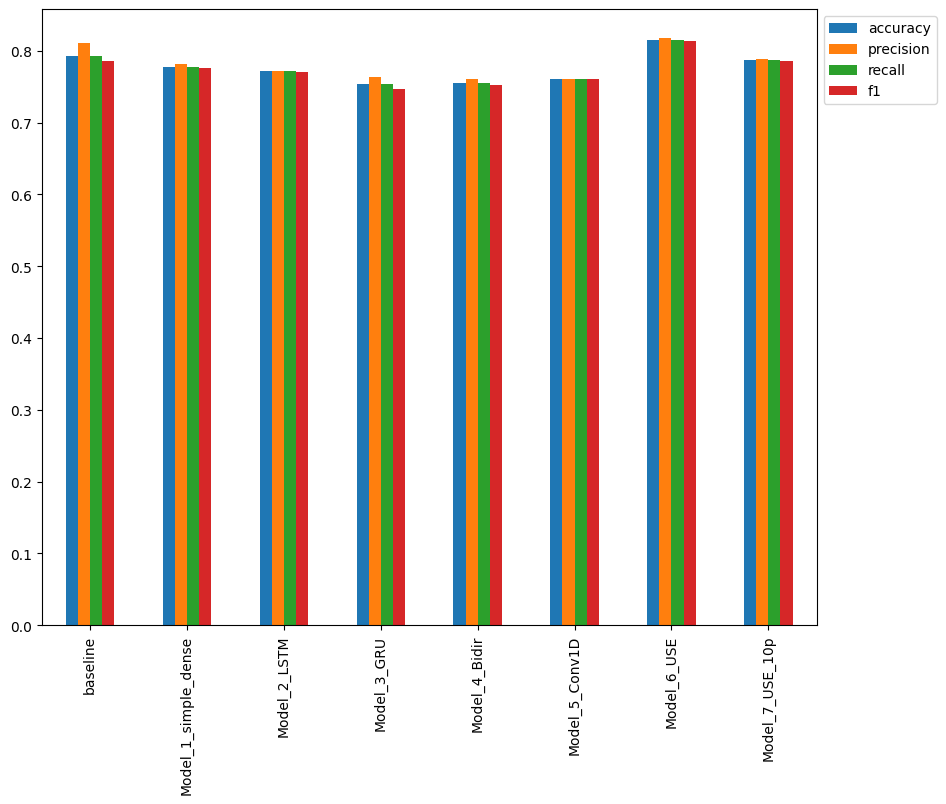

In [ ]:
all_models_results.plot(kind="bar", fontsize=10, figsize=(10, 8)).legend(bbox_to_anchor=(1.0, 1.0)) # Plot and compare all of the model results

<Axes: title={'center': 'F1_SCORE'}>

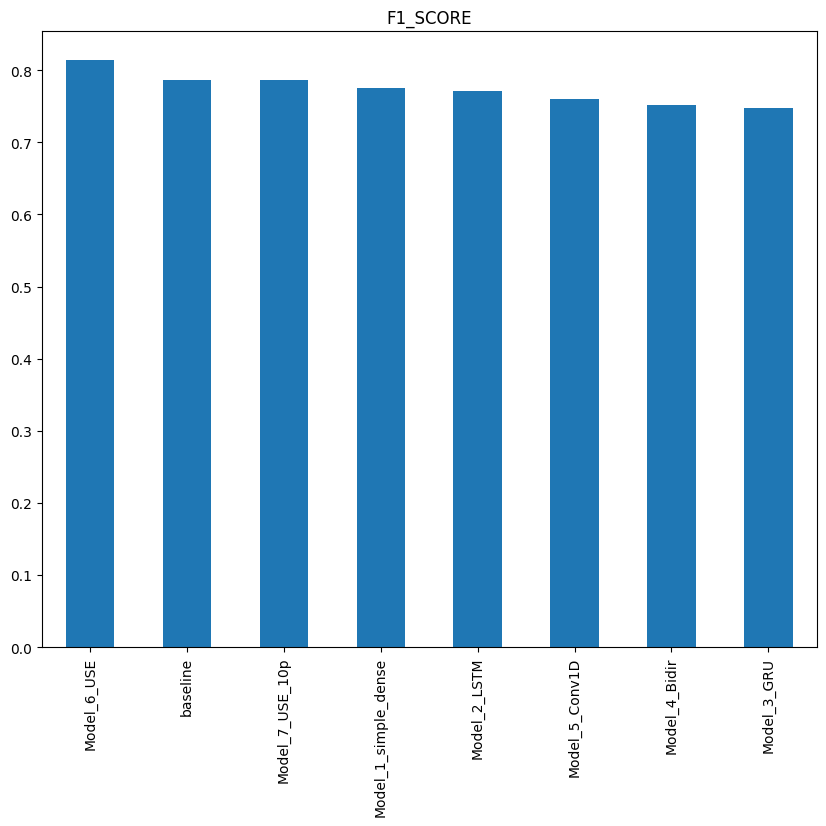

In [ ]:
all_models_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", fontsize=10, figsize=(10, 8), title="F1_SCORE") # Sort model results by f1-score

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir model_logs/

## Saving and loading a trained model

In [ ]:
model6.save("Saved_model_6.h5") # Save TF Hub Sentence Encoder model to HDF5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model_6=tf.keras.models.load_model("/content/Saved_model_6.h5", custom_objects={"KerasLayer": hub.KerasLayer}) # Load model with custom Hub Layer (required HDF5 format)

In [ ]:
loaded_model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


## Finding the most wrong examples

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip" # Download a pretrained model from Google Storage

--2024-01-02 13:24:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  35.0MB/s    in 17s     

2024-01-02 13:25:14 (54.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [ ]:
unzip_data("/content/08_model_6_USE_feature_extractor.zip")

In [ ]:
USE_FE=tf.keras.models.load_model("/content/08_model_6_USE_feature_extractor", custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
USE_FE.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Make predictions with the loaded model from GS
model6_pretrained_probs=USE_FE.predict(val_sen)
model6_pretrained_preds=tf.squeeze(tf.round(model6_pretrained_probs))

24/24 [==============================] - 1s 17ms/step


In [ ]:
model6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sen,
                       "target": val_labels,
                       "pred": model6_pretrained_preds,
                       "pred_prob": tf.squeeze(model6_pretrained_probs)})


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
# Check the false negatives (model predicted 1 when should've been 0)
for row in most_wrong[-10:].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.0420868508517

## Making predictions on the test dataset


In [ ]:
test_text=test_df["text"].to_list() # Making predictions on the test dataset and visualizing them

In [ ]:
Test_pred_probs=USE_FE.predict(test_text)

102/102 [==============================] - 1s 8ms/step


In [ ]:
Test_preds=tf.squeeze(tf.round(Test_pred_probs))

In [ ]:
TEST_DF=pd.DataFrame({"Text": test_text,
                      "Pred": Test_preds,
                      "pred_prob": tf.squeeze(Test_pred_probs)})


,Text,Pred,pred_prob
0,Just happened a terrible car crash,1.0,0.519970
1,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958


In [ ]:
for row in TEST_DF[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, pred, prob = row
  print(f"Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Pred: 1, Prob: 0.5199701189994812
Text:
Just happened a terrible car crash

----

Pred: 1, Prob: 0.875251293182373
Text:
Heard about #earthquake is different cities, stay safe everyone.

----

Pred: 1, Prob: 0.8278329968452454
Text:
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all

----

Pred: 1, Prob: 0.9335067272186279
Text:
Apocalypse lighting. #Spokane #wildfires

----

Pred: 1, Prob: 0.967958390712738
Text:
Typhoon Soudelor kills 28 in China and Taiwan

----

Pred: 1, Prob: 0.5556339621543884
Text:
We're shaking...It's an earthquake

----

Pred: 0, Prob: 0.06342779844999313
Text:
They'd probably still show more life than Arsenal did yesterday, eh? EH?

----

Pred: 0, Prob: 0.045102737843990326
Text:
Hey! How are you?

----

Pred: 0, Prob: 0.04864755645394325
Text:
What a nice hat?

----

Pred: 0, Prob: 0.061762671917676926
Text:
Fuck off!

----

